In [2]:
import pandas as pd


In [5]:
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [4]:
df.describe(include='all')

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
count,374.000000,374,374.000000,374,374.000000,374.000000,374.000000,374.000000,374,374,374.000000,374.000000,155
unique,NaN,2,NaN,11,NaN,NaN,NaN,NaN,4,25,NaN,NaN,2
top,NaN,Male,NaN,Nurse,NaN,NaN,NaN,NaN,Normal,130/85,NaN,NaN,Sleep Apnea
freq,NaN,189,NaN,73,NaN,NaN,NaN,NaN,195,99,NaN,NaN,78
mean,187.500000,NaN,42.184492,NaN,7.132086,7.312834,59.171123,5.385027,NaN,NaN,70.165775,6816.844920,NaN
std,108.108742,NaN,8.673133,NaN,0.795657,1.196956,20.830804,1.774526,NaN,NaN,4.135676,1617.915679,NaN
min,1.000000,NaN,27.000000,NaN,5.800000,4.000000,30.000000,3.000000,NaN,NaN,65.000000,3000.000000,NaN
25%,94.250000,NaN,35.250000,NaN,6.400000,6.000000,45.000000,4.000000,NaN,NaN,68.000000,5600.000000,NaN
50%,187.500000,NaN,43.000000,NaN,7.200000,7.000000,60.000000,5.000000,NaN,NaN,70.000000,7000.000000,NaN
75%,280.750000,NaN,50.000000,NaN,7.800000,8.000000,75.000000,7.000000,NaN,NaN,72.000000,8000.000000,NaN


In [8]:
##LLM for complete the cleaning

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def clean_and_preprocess(path_csv, target_col='Sleep Disorder'):
    # 1. Load dataset
    df = pd.read_csv(path_csv)
    print("Initial shape:", df.shape)
    
    # 2. Drop unnecessary columns
    if 'Person ID' in df.columns:
        df = df.drop(columns=['Person ID'])
    
    # 3. Clean / split complex columns
    # Example: Blood Pressure “120/80”
    if 'Blood Pressure' in df.columns:
        bp = df['Blood Pressure'].astype(str).str.split('/', expand=True)
        # Some entries might be malformed — use errors='coerce'
        df['BP_Systolic'] = pd.to_numeric(bp[0], errors='coerce')
        df['BP_Diastolic'] = pd.to_numeric(bp[1], errors='coerce')
        df = df.drop(columns=['Blood Pressure'])
    
    # 4. Handle missing values
    # For target, we might drop rows without target
    if target_col in df.columns:
        df = df.dropna(subset=[target_col])
    # For numeric features: impute with mean
    # For categorical: impute with “missing” or most frequent
    # We'll set that in the pipeline
    
    # 5. Encode / scale using pipeline
    # Identify categorical & numeric cols
    # We do this *after* initial cleaning, so that e.g. BP_Systolic etc are present
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    # Drop target from features
    if target_col in cat_cols:
        cat_cols.remove(target_col)
    if target_col in num_cols:
        num_cols.remove(target_col)
    
    # If you already encoded Gender (e.g. map to 0/1), then it's numeric and is in num_cols.
    # If not, it will be in cat_cols and get OneHotEncoded.
    
    # Make transformers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing strings
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)
        ],
        remainder='passthrough'  # in case any columns remain
    )
    
    # 6. Split into X and y
    X = df.drop(columns=[target_col]) if target_col in df.columns else df.copy()
    y = df[target_col] if target_col in df.columns else None
    
    # 7. Fit / transform
    X_processed = preprocessor.fit_transform(X)
    
    # 8. Get feature names (optional, for debugging)
    # For numeric: names are num_cols
    # For categorical: get onehot names
    cat_ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = cat_ohe.get_feature_names_out(cat_cols)
    final_feature_names = num_cols + list(cat_feature_names)
    # If passthrough adds extra columns, you might need to adjust names manually
    
    X_df = pd.DataFrame(X_processed, columns=final_feature_names)
    
    print("Processed X shape:", X_df.shape)
    if y is not None:
        print("Target distribution:\n", y.value_counts(dropna=False))
    
    return X_df, y, preprocessor

# Example usage
csv_path = 'Sleep_health_and_lifestyle_dataset.csv'
X, y, processor = clean_and_preprocess(csv_path, target_col='Sleep Disorder')
X.head(), y.head()


Initial shape: (374, 13)
Processed X shape: (155, 22)
Target distribution:
 Sleep Disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64


(        Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
 0 -2.384477       -1.183160         -2.153758                -1.502214   
 1 -2.384477       -1.183160         -2.153758                -1.502214   
 2 -2.384477       -1.183160         -2.153758                -1.502214   
 3 -2.256501       -0.664377         -0.653387                -1.016010   
 4 -2.256501       -0.404986         -1.403573                -1.016010   
 
    Stress Level  Heart Rate  Daily Steps  BP_Systolic  BP_Diastolic  \
 0      1.150372    2.555381    -1.994809     0.943896      0.039884   
 1      1.150372    2.555381    -1.994809     0.943896      0.039884   
 2      1.150372    2.555381    -1.994809     0.943896      0.039884   
 3      0.635032    1.975179    -1.729951     0.943896      0.039884   
 4      0.635032    1.588379    -1.465093    -0.543310     -0.578316   
 
    Gender_Male  ...  Occupation_Lawyer  Occupation_Nurse  \
 0          1.0  ...                0.0              

                              Age  Sleep Duration  Quality of Sleep  \
Age                      1.000000        0.550193          0.710221   
Sleep Duration           0.550193        1.000000          0.916748   
Quality of Sleep         0.710221        0.916748          1.000000   
Physical Activity Level  0.604725        0.240760          0.352021   
Stress Level            -0.452398       -0.848873         -0.872084   

                         Physical Activity Level  Stress Level  Heart Rate  \
Age                                     0.604725     -0.452398   -0.373515   
Sleep Duration                          0.240760     -0.848873   -0.337888   
Quality of Sleep                        0.352021     -0.872084   -0.534720   
Physical Activity Level                 1.000000     -0.026627    0.101348   
Stress Level                           -0.026627      1.000000    0.598860   

                         Daily Steps  BP_Systolic  BP_Diastolic  Gender_Male  \
Age                     

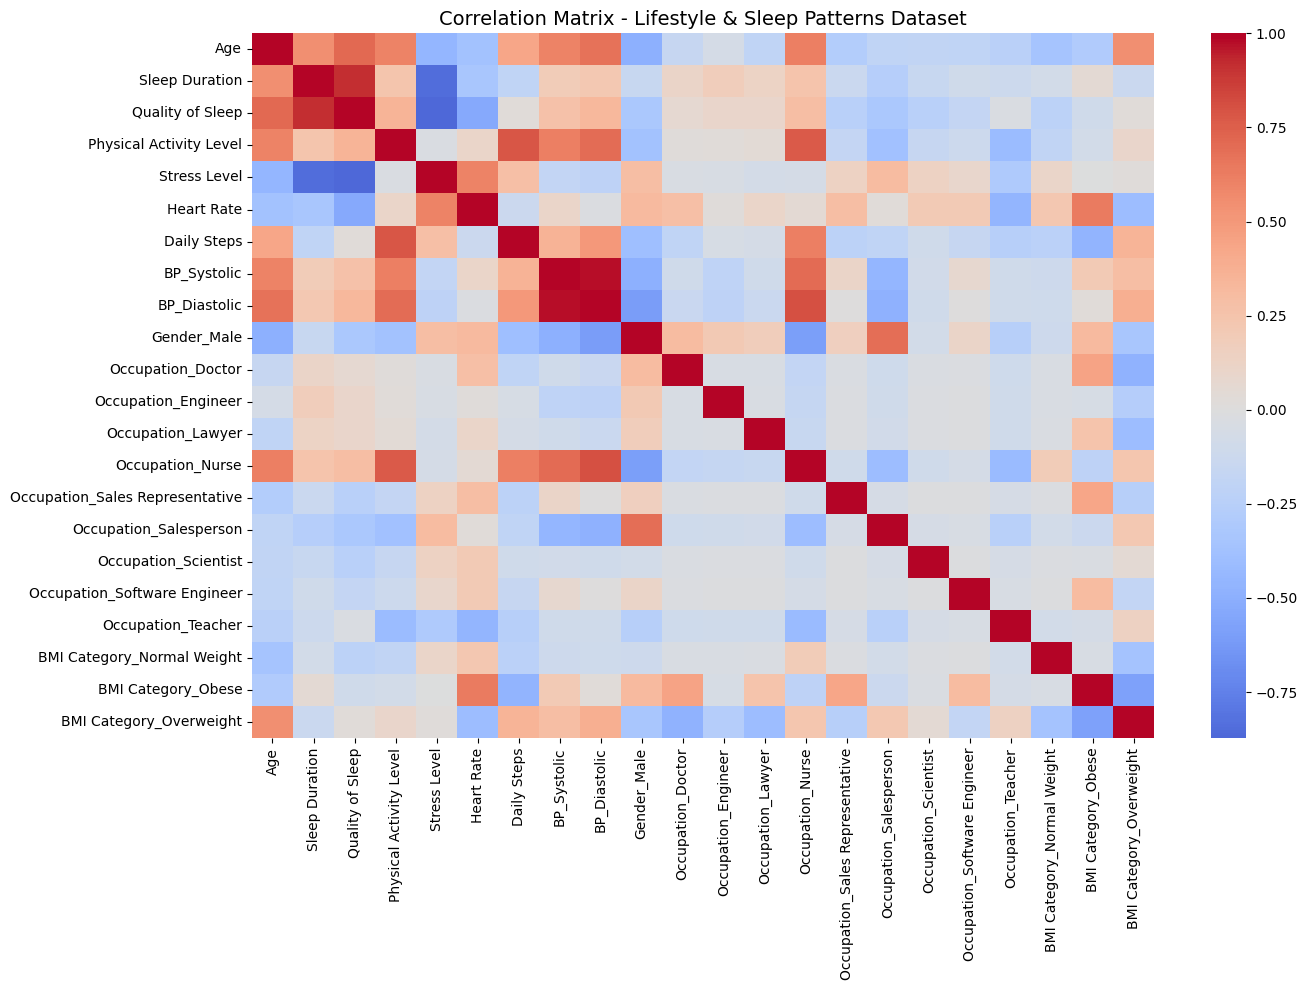

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_df is your cleaned & encoded dataframe (numeric)
# If not, make sure to convert it to a DataFrame with column names as shown earlier

corr_matrix = X.corr(numeric_only=True)  # ensures only numeric columns are used

# Display top correlations (optional)
print(corr_matrix.head())

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=False,          # set True to show values
    cmap='coolwarm',      # diverging color map
    center=0,
    cbar=True
)
plt.title("Correlation Matrix - Lifestyle & Sleep Patterns Dataset", fontsize=14)
plt.tight_layout()
plt.show()
